In [1]:
import os
from gan_utils import gan
from gan_utils import gan_trainer
from gan_utils import my_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import torch
os.environ["CUDA_VISIBLE_DEVICES"]="2"
torch.backends.cuda.max_split_size_mb = 16

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths and directories
project_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_dir, "dataset", "sprites_1788_16_16.npy")
test_dir = os.path.join(project_dir, "test_gan", "test4")
checkpoint = os.path.join(test_dir, "checkpoint_119.pth")

# Create directories if they don't exist
os.makedirs(test_dir, exist_ok=True)

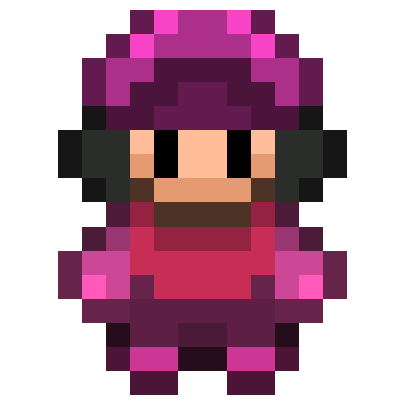

In [3]:
# visualize the image
images = np.load(data_dir)
image = images[0]
# visualize
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(image)
plt.savefig(os.path.join(test_dir, "example.png"))

In [4]:
# Config
z_dim = 200
image_size = (3, 16, 16)
batch_size = 2
epochs = 61
lr_gen = 0.0002
lr_dis = 0.0001
train_enable = False

In [5]:
# Dataset
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
dataset = my_dataset.MyDataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Initialize Generator and Discriminator
generator = gan.Generator(z_dim=z_dim, num_filters=64, target_image_size=image_size)
discriminator = gan.Discriminator(image_size=image_size, num_filters=64)

# Create GAN trainer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = gan_trainer.GANTrainer(
    generator, discriminator, z_dim=z_dim, dataloader=dataloader, batch_size=batch_size, device=device, lr_gen=lr_gen, lr_dis=lr_dis)

In [7]:
# Load checkpoint
if os.path.exists(checkpoint):
    start_epoch = trainer.load_checkpoint(checkpoint) + 1
else:
    start_epoch = 0

Loaded checkpoint from epoch 119 with gen_loss=0.02730220928788185, dis_loss=-0.005030624568462372


In [8]:
# Train GAN
if train_enable:
    trainer.train(epochs=epochs, save_dir=test_dir, start_epoch=start_epoch)

In [9]:
# Sampling
z = torch.randn(1, z_dim, device=device)
output = generator(z)

In [10]:
def visualize(output, save_path=None):
    # Move tensor to CPU and convert to Numpy array
    image = output.cpu().detach().numpy()

    # If image is in [C, H, W] format, need to transpose it to [H, W, C]
    if image.shape[0] in [3, 4]:
        image = image.transpose(1, 2, 0)
        
    # If image has pixel values between [0, 1], need to rescale them to [0, 255]
    if image.max() <= 1.0:
        image *= 255
    
    plt.imshow(image.astype('uint8'))
    
    # If save_path is provided, save the image to the specified path
    if save_path:
        plt.savefig(save_path)

    plt.show()

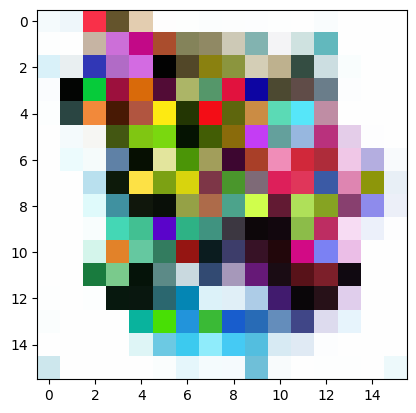

In [11]:
visualize(output[0], os.path.join(test_dir, "result.png"))